<a href="https://colab.research.google.com/github/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_2_First_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer
Предыдущая часть: https://github.com/Lamblador/IR_expert_system/blob/main/Koshelev_IR_expert_system_1_Dataset_Preparation.ipynb

-Work in progress (last updated:20/03/2023)-

B. Цель данного блокнота

Целью этого блокнота является обучение примитивной модели распознавания всего лишь 15 классов (функциональных групп) в спектре из 1800 точек в диапазоне 500-4100 [1/cm] 

C. План реализации

1. Импортировать табличные данные разметки классов по CAS и табличные данные уже обработанных спектров нужного диапазона.
2. Создать объект класса Dataset
3. Реализовать код для обучения модели.
4. Реализовать саму модель.
5. Обучить модель.
6. Оценить точность модели в мультиклассовом анализе (label_ranking_average_precision_score).
7. Собрать статистику.

NOTES
1. Импортированы табличные данные.
2. Написана несколько версий модели. 
3. Разработаны функции для описания статистики модели.
4. Применен планировщик обучения. Получена точность 0,8.
5. Составлен план по аугментации.

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [1]:
!git clone https://github.com/Lamblador/IR_expert_system.git

Cloning into 'IR_expert_system'...
remote: Enumerating objects: 16768, done.
remote: Counting objects: 100% (1925/1925), done.
remote: Compressing objects: 100% (1871/1871), done.
remote: Total 16768 (delta 72), reused 1896 (delta 53), pack-reused 14843
Receiving objects: 100% (16768/16768), 244.46 MiB | 11.40 MiB/s, done.
Resolving deltas: 100% (432/432), done.
Updating files: 100% (16623/16623), done.


In [2]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install --upgrade jcamp
!pip install torchmetrics
clear_output()

In [3]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
import numpy as np
import torch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

# Импорт табличных данных

In [4]:
labels_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
labels_df = labels_df.set_index("CAS")
labels_df

,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,alkyne,...,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Импорт данных и обработка спектров

In [5]:
from jcamp import jcamp_readfile
nist_ir_spectra_list_with_group = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_inchi_group_list.csv')
# Create an empty list to store spectra data
ref_spectra = []
# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('/content/IR_expert_system/downloaded_jcamp/ir/*')  # look for files without extension. Returns a list.
# Try to read the file. If can't be read, skip it.
dataset_dic = {}
for i, file in enumerate(files):
    
    #print(file)
    try:
        # read jcamp file using the jcamp class and store data into the
        # ref_spectra list
        sample = jcamp_readfile(file)
        #Forming data into the types
        sample['x'] = sample['x'].astype(np.float32)
        sample['y'] = sample['y'].astype(np.float32)
        sample['firstx'] = np.float32(sample['x'][0])
        #print(type(sample['firstx']))
        sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
        sample['npoints'] = int(sample['npoints'])    
        # uniformize data, #1:
        # check yunits: If yunits is in transmission, change it to absorbance.
        # Later create a function to uniformize units
        if sample['yunits'] == "ABSORBANCE":
            pass 

        elif sample['yunits'] == "TRANSMISSION" or sample['yunits'] == "TRANSMITTANCE":
            
            sample['y'] = 1 - sample['y']
            sample['yunits'] = "ABSORBANCE"
            
            #normalize
           
        # check xunits: if in microns, change to 1/cm

        if sample['xunits'] == "MICROMETERS":
            sample['x'] = 10000 / sample['x']
            sample['xunits'] = '1/CM'
            sample['firstx'] = np.float32(sample['x'][0])
            sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
            sample['deltax'] = ((np.float32(sample['firstx'])-np.float32(sample['lastx']))/np.float32(sample['npoints']))
            #if sample['deltax'] == np.nan: print(float(sample['firstx'])-float(sample['lastx'])), float(sample['npoints'])
            sample['maxx'] =  np.float32(max(sample['x']))
            sample['minx'] =  np.float32(min(sample['x']))
        # check deltax: if Nan, change to (maxx-minx)/npoints
        #if sample['deltax'] == np.nan: sample['deltax'] = ((float(sample['firstx'])-float(sample['lastx']))/float(sample['npoints']))

        # !Still need to uniformize x-axis range and uniformize x-axis intervals.
        #Flitting the x array if it is not in min_to_max order
        if sample['x'][0] > sample['x'][3]: 
           #print(sample['x'])
           sample['x'] = np.flip(sample['x'])
           #print(sample['x'])
           sample['y'] = np.flip(sample['y'])
           sample['firstx'] = np.float32(sample['x'][0])
           sample['lastx'] = np.float32(sample['x'][int(sample['npoints'])-1])
           
        
        #Saving data to dictionary under cas num
        dataset_dic[sample['cas registry no']] = sample
        #print(sample['cas registry no'])
        # Nan check
        if np.isnan(sample['y']).any(): print("Reading jcamp problem! Nan observed in Y")
                

    except:
         print("File can't be read, please check:", file)
         continue

#print(dataset_dic)

File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/5414-19-7
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/1570-64-5
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/79-06-1
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/119-84-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/100062-58-6
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/531-75-9
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/2867-05-2
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/16960-08-0
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116436-35-2
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/116594-65-1
File can't be read, please check: /content/IR_expert_system/downloaded_jcamp/ir/1878-49-5
File ca

In [6]:
dataset_df = pd.DataFrame(dataset_dic)
dataset_df = dataset_df.transpose()
dataset_df[['x', 'y', 'minx', 'maxx', 'npoints']]

,x,y,minx,maxx,npoints
495-10-3,"[600.0, 601.18646, 602.37286, 603.5593, 604.74...","[0.37300003, 0.37199998, 0.37, 0.37, 0.3679999...",600,3882.88,2768
3018-12-0,"[520.27, 521.62134, 522.9727, 524.3241, 525.67...","[0.93299997, 0.93299997, 0.931, 0.929, 0.929, ...",520.27,3893.26,2497
70289-17-7,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.07727823, 0.036729623, 0.02617126, 0.010446...",450,3966,880
2998-08-5,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0001505, 0.0001548, 6.88e-05, 3.01e-05, 9.0...",550,3846,825
5847-55-2,"[666.04504, 666.2671, 666.4893, 666.7117, 666....","[0.286, 0.28500003, 0.286, 0.286, 0.28500003, ...",666.045044,4926.108398,2601
...,...,...,...,...,...
37529-29-6,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.01686, 0.01666, 0.01618, 0.01529, 0.01429, ...",549.759,4000.7,1790
3794-15-8,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.002095, 0.001805, 0.001495, 0.0012978, 0.00...",549.759,4000.7,1790
16365-27-8,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[0.00173, 0.00182, 0.00164, 0.00144, 0.00156, ...",549.759,4000.7,1790
116660-51-6,"[625.2188, 625.4109, 625.60254, 625.79425, 625...","[0.245, 0.245, 0.24800003, 0.24900001, 0.24900...",625.218811,4972.650391,2857


In [7]:
#Добавление к краям с исходным шагом крайнего значения y.
def padding_ir_below(x, y, low_border):
  '''
    x, y - array-like data
    low_border - border until which padding will continue 

    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[0]-deltax
  while next_x > low_border:
    x.insert(0, next_x)
    y.insert(0, y[0])
    next_x = x[0]-deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.insert(0, next_x)
  y.insert(0, y[0])
  next_x = x[0]-deltax
  return x, y

def padding_ir_above(x, y, high_border):
  '''
    x, y - array-like data
    high_border - border until which padding will continue 


    return padded x and y as lists
  '''
  x, y = list(x), list(y)
  deltax = x[1]-x[0]
  next_x = x[-1]+deltax
  while next_x < high_border:
    x.append(next_x)
    y.append(y[-1])
    next_x = x[-1]+deltax
  #Последняя итерация чтобы выйти за границу интерполирования
  x.append(next_x)
  y.append(y[-1])
  next_x = x[-1]+deltax
  return x, y

from scipy import interpolate

def interpolate_in_borders_with_delta(x, y, borders = [500, 4100], deltax = 2):
  '''
  x, y - array like data
  borders - list of [low_border, high border]
  deltax - increment of new data

  returns new x, y data as lists with increment = deltax
  '''
  x, y = list(x), list(y)
  f = interpolate.interp1d(x, y)
  #print(f(x[0]))
  x_new = []
  for i in range(borders[0], borders[1], deltax):
    x_new.append(i)
  x_new = np.array(x_new)
  y_new = f(x_new)
  
  return x_new, y_new



In [8]:
x_list, y_list = [], []
errors = 0
for i in tqdm(range(len(dataset_df[['x']]))):
  try:
      x, y = dataset_df[['x']].iloc[i].tolist(), dataset_df[['y']].iloc[i].tolist()
      x1, y1 = padding_ir_below(x[0], y[0], 500.0)

      x2, y2 = padding_ir_above(x1, y1, 4100.0)
  
      x3, y3 = interpolate_in_borders_with_delta(x2, y2)
      x_list.append(x3)
      y_list.append(y3)
  except ValueError:
      #print(f'0: {len(x)}, {len(y)}, 1: {len(x1)}, {len(y1)}, 2: {len(x2)}, {len(y2)}')
      errors +=1
      x_list.append(np.nan)
      y_list.append(np.nan) 
print(f'Found {errors} errors')

100%|██████████| 14346/14346 [01:01<00:00, 233.78it/s]

Found 38 errors


In [9]:
x_serie = pd.Series(x_list)
y_serie = pd.Series(y_list)

In [10]:
df = pd.DataFrame(x_serie, columns = ['x1'])
df['y1'] = y_serie
df

,x1,y1
0,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.37300002574920654, 0.37300002574920654, 0.3..."
1,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.9329999685287476, 0.9329999685287476, 0.932..."
2,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.010277554858475924, 0.010783008299767971, 0..."
3,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.00015049999637994915, 0.0001504999963799491..."
4,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.28600001335144043, 0.28600001335144043, 0.2..."
...,...,...
14341,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.016860000789165497, 0.016860000789165497, 0..."
14342,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.002094999887049198, 0.002094999887049198, 0..."
14343,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0017300000181421638, 0.0017300000181421638,..."
14344,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.24500000476837158, 0.24500000476837158, 0.2..."


In [11]:
dataset_df = dataset_df.reset_index()
dataset_df1 = dataset_df.join(df, lsuffix='x')
dataset_df1[['x', 'x1', 'y', 'y1']]

,x,x1,y,y1
0,"[600.0, 601.18646, 602.37286, 603.5593, 604.74...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.37300003, 0.37199998, 0.37, 0.37, 0.3679999...","[0.37300002574920654, 0.37300002574920654, 0.3..."
1,"[520.27, 521.62134, 522.9727, 524.3241, 525.67...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.93299997, 0.93299997, 0.931, 0.929, 0.929, ...","[0.9329999685287476, 0.9329999685287476, 0.932..."
2,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.07727823, 0.036729623, 0.02617126, 0.010446...","[0.010277554858475924, 0.010783008299767971, 0..."
3,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0001505, 0.0001548, 6.88e-05, 3.01e-05, 9.0...","[0.00015049999637994915, 0.0001504999963799491..."
4,"[666.04504, 666.2671, 666.4893, 666.7117, 666....","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.286, 0.28500003, 0.286, 0.286, 0.28500003, ...","[0.28600001335144043, 0.28600001335144043, 0.2..."
...,...,...,...,...
14341,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.01686, 0.01666, 0.01618, 0.01529, 0.01429, ...","[0.016860000789165497, 0.016860000789165497, 0..."
14342,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.002095, 0.001805, 0.001495, 0.0012978, 0.00...","[0.002094999887049198, 0.002094999887049198, 0..."
14343,"[549.759, 551.688, 553.617, 555.546, 557.475, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.00173, 0.00182, 0.00164, 0.00144, 0.00156, ...","[0.0017300000181421638, 0.0017300000181421638,..."
14344,"[625.2188, 625.4109, 625.60254, 625.79425, 625...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.245, 0.245, 0.24800003, 0.24900001, 0.24900...","[0.24500000476837158, 0.24500000476837158, 0.2..."


In [12]:
dataset_df1['y1'][0]

array([0.37300003, 0.37300003, 0.37300003, ..., 0.06900001, 0.06900001,
       0.06900001])

In [13]:
dataset_df1 = dataset_df1.set_index('cas registry no')

In [14]:
dataset_df_labeled = labels_df.join(dataset_df1)
dataset_df_labeled

,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,alkyne,...,apodization,folding limits,number of interferograms averaged per single channel spectrum,sample description,temperature,$spectra version,$uncertainty in y,pressure,x1,y1
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.026076922193169594, 0.02797572687268257, 0...."
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.005049999803304672, 0.005049999803304672, 0..."
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0002783999952953309, 0.0002783999952953309,..."
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.08899998664855957, 0.08958601189397797, 0.0..."
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.20800000429153442, 0.20800000429153442, 0.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.02355931419879198, 0.02319779060781002, 0.0..."
999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0013761000009253621, 0.0013761000009253621,..."
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13220000267028809, 0.1312999725341797, 0.12..."


In [15]:
dataset_df_labeled.columns

Index(['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne', 'alcohols', 'amines', 'nitriles',
       'aromatics', 'alkyl halides', 'esters', 'ketones', 'aldehydes',
       'carboxylic acids', 'ether', 'acyl halides', 'amides', 'nitro', 'index',
       'title', 'jcamp-dx', 'data type', 'class', 'origin', 'owner', 'date',
       'names', 'molform', 'source reference', '$nist source', '$nist image',
       'spectrometer/data system', 'instrument parameters', 'state',
       'path length', 'sampling procedure', 'resolution', 'data processing',
       'xunits', 'yunits', 'xfactor', 'yfactor', 'deltax', 'firstx', 'lastx',
       'firsty', 'maxx', 'minx', 'maxy', 'miny', 'npoints', 'xydata', 'end',
       'x', 'y', 'filename', 'bp', 'mp', 'xlabel', 'ylabel', '$nist doc file',
       'aperture', 'external diffuse reflectance accessory', 'beamsplitter',
       'detector (dia. det. port in sphere)', 'sphere diameter',
       'acquisition mode', '

In [16]:
dataset_df_labeled1 = dataset_df_labeled[['Name', 'Formula', 'Mw', 'Elements', 'InChi', 'SMILES', 'alkane',
       'methyl', 'alkene', 'alkyne', 'alcohols', 'amines', 'nitriles',
       'aromatics', 'alkyl halides', 'esters', 'ketones', 'aldehydes',
       'carboxylic acids', 'ether', 'acyl halides', 'amides', 'nitro',
       'title',
       'molform',
       'x', 'y', 'x1', 'y1']]
dataset_df_labeled1

,Name,Formula,Mw,Elements,InChi,SMILES,alkane,methyl,alkene,alkyne,...,ether,acyl halides,amides,nitro,title,molform,x,y,x1,y1
CAS,,,,,,,,,,,,,,,,,,,,,
100-00-5,"Benzene, 1-chloro-4-nitro-",C6H4ClNO2,156.993056,"['C', 'H', 'Cl', 'N', 'O']",InChI=1/C6H4ClNO2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H,[O-][N+](=O)c1ccc(Cl)cc1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,"Benzene, 1-chloro-4-nitro-",C 6 H 4 Cl N O 2,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.025064226, 0.03873562, 0.039495144, 0.01962...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.026076922193169594, 0.02797572687268257, 0...."
100-01-6,p-Nitroaniline,C6H6N2O2,138.042927,"['C', 'H', 'N', 'O']",InChI=1/C6H6N2O2/c7-5-1-3-6(4-2-5)8(9)10/h1-4H...,Nc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,p-Nitroaniline,C 6 H 6 N 2 O 2,"[551.688, 555.546, 559.404, 563.262, 567.12, 5...","[0.00505, 0.00536, 0.00556, 0.00599, 0.00634, ...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.005049999803304672, 0.005049999803304672, 0..."
100-02-7,"Phenol, 4-nitro-",C6H5NO3,139.026943,"['C', 'H', 'N', 'O']","InChI=1/C6H5NO3/c8-6-3-1-5(2-4-6)7(9)10/h1-4,8H",Oc1ccc(cc1)[N+]([O-])=O,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4-Nitrophenol,C 6 H 5 N O 3,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0002784, 0.0001464, 0.0001752, 0.0002928, 0...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0002783999952953309, 0.0002783999952953309,..."
1000-49-3,N-butyltrimethylsilane,C7H18Si,130.117777,"['C', 'H', 'Si']","InChI=1/C7H18Si/c1-5-6-7-8(2,3)4/h5-7H2,1-4H3",CCCC[Si](C)(C)C,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,n-BUTYLTRIMETHYLSILANE,C7 H18 Si,"[203.607, 204.53778, 205.46855, 206.39932, 207...","[0.19099998, 0.19099998, 0.19099998, 0.1909999...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.08899998664855957, 0.08958601189397797, 0.0..."
1000-50-6,N-Butyldimethylchlorosilane,C6H15ClSi,150.063155,"['C', 'H', 'Cl', 'Si']","InChI=1/C6H15ClSi/c1-4-5-6-8(2,3)7/h4-6H2,1-3H3",CCCC[Si](C)(C)Cl,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,n-BUTYL CHLORODIMETHYL SILANE,C6 H15 Cl Si,"[625.2462, 625.5054, 625.7648, 626.0244, 626.2...","[0.208, 0.208, 0.20899999, 0.208, 0.208, 0.208...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.20800000429153442, 0.20800000429153442, 0.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99-97-8,"Benzenamine, N,N,4-trimethyl-",C9H13N,135.104799,"['C', 'H', 'N']","InChI=1/C9H13N/c1-8-4-6-9(7-5-8)10(2)3/h4-7H,1...",CN(C)c1ccc(C)cc1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"Benzenamine, N,N,4-trimethyl-",C 9 H 13 N,"[450.0, 454.0, 458.0, 462.0, 466.0, 470.0, 474...","[0.006145908, 0.006989464, 0.008676576, 0.0113...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.02355931419879198, 0.02319779060781002, 0.0..."
999-78-0,"2-Pentyne, 4,4-dimethyl-",C7H12,96.093900,"['C', 'H']","InChI=1/C7H12/c1-5-6-7(2,3)4/h1-4H3",CC#CC(C)(C)C,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,"4,4-Dimethyl-2-pentyne",C 7 H 12,"[550.0, 554.0, 558.0, 562.0, 566.0, 570.0, 574...","[0.0013761, 0.0011286, 0.0008943, 0.0006864, 0...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.0013761000009253621, 0.0013761000009253621,..."
999-81-5,"Ammonium chloride, 2-chloroethyltrimethyl-",C5H13ClN.Cl,157.042505,"['C', 'H', 'Cl', 'N', 'Cl']","InChI=1/C5H13ClN.ClH/c1-7(2,3)5-4-6;/h4-5H2,1-...",[Cl-].C[N+](C)(C)CCCl,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"Ammonium chloride, 2-chloroethyltrimethyl-",C5 H13 Cl2 N,"[459.0, 460.0, 461.0, 462.0, 463.0, 464.0, 465...","[0.15679997, 0.15499997, 0.15319997, 0.1513000...","[500, 502, 504, 506, 508, 510, 512, 514, 516, ...","[0.13220000267028809, 0.1312999725341797, 0.12..."


In [17]:
spectra_x =dataset_df_labeled.iloc[:,-1]
spectra_x_t = torch.Tensor(spectra_x[0])
spectra_x_t

tensor([0.0261, 0.0280, 0.0325,  ..., 0.0071, 0.0071, 0.0071])

# Создание класса Dataset

Вивлеты - преобразование для детектирования пиков.

In [18]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,6:23]
        self.spectra_x = self.dataset_df.iloc[:,-2]
        self.spectra_y = self.dataset_df.iloc[:,-1]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800))      
        spectra = torch.cat((spectra_x, spectra_y))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [19]:
dataset_ir_spectra = IRSpectraDataset(dataset_df_labeled1)

In [20]:
spectra, label = dataset_ir_spectra.__getitem__(0)
spectra.size()

torch.Size([2, 1800])

In [21]:
#Создание объекта класса и разбиение на трейн,тест и вал
from torch.utils.data import random_split
dataset_ir_spectra = IRSpectraDataset(dataset_df_labeled1.dropna())
train_size = int(0.7 * len(dataset_ir_spectra))
val_size = int(0.1 * len(dataset_ir_spectra))
test_size = len(dataset_ir_spectra) - train_size - val_size
train_dataset, test_dataset = random_split(dataset_ir_spectra, [train_size, int(test_size+val_size)])
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

In [22]:
#Создание загрузчиков
# Number of classes
classes = list(dataset_ir_spectra.spectra_labels.columns)
num_classes = len(classes)
num_classes

17

In [23]:
cls2inx = {}
inx2cls= {}
for i, classs in enumerate(classes):
  cls2inx[f'{classs}']= i
  inx2cls[i] = classs
print(cls2inx)
print(inx2cls)

{'alkane': 0, 'methyl': 1, 'alkene': 2, 'alkyne': 3, 'alcohols': 4, 'amines': 5, 'nitriles': 6, 'aromatics': 7, 'alkyl halides': 8, 'esters': 9, 'ketones': 10, 'aldehydes': 11, 'carboxylic acids': 12, 'ether': 13, 'acyl halides': 14, 'amides': 15, 'nitro': 16}
{0: 'alkane', 1: 'methyl', 2: 'alkene', 3: 'alkyne', 4: 'alcohols', 5: 'amines', 6: 'nitriles', 7: 'aromatics', 8: 'alkyl halides', 9: 'esters', 10: 'ketones', 11: 'aldehydes', 12: 'carboxylic acids', 13: 'ether', 14: 'acyl halides', 15: 'amides', 16: 'nitro'}


In [24]:
dataset_ir_spectra.spectra_labels['alkane'].mean()

0.6827464492814522

In [25]:
# Расчёт весов
wts4cls = {}
for classs in classes:
  wts4cls[classs] = dataset_ir_spectra.spectra_labels[classs].mean()
print(wts4cls)

{'alkane': 0.6827464492814522, 'methyl': 0.6216488780569795, 'alkene': 0.13555760988318347, 'alkyne': 0.019497436759391546, 'alcohols': 0.21867383813765862, 'amines': 0.13085133204470964, 'nitriles': 0.03815446676191277, 'aromatics': 0.5847550214303723, 'alkyl halides': 0.2593495251701824, 'esters': 0.11648037650222708, 'ketones': 0.09420959744516345, 'aldehydes': 0.020589965543322968, 'carboxylic acids': 0.06025716446760232, 'ether': 0.25018909152029584, 'acyl halides': 0.00966467770400874, 'amides': 0.07101437095554249, 'nitro': 0.05723170014286915}


In [26]:
wts_list = []
for name, values in wts4cls.items():
  wts_list.append(values)
weight_for_every_class = torch.tensor(wts_list)
print(weight_for_every_class)

tensor([0.6827, 0.6216, 0.1356, 0.0195, 0.2187, 0.1309, 0.0382, 0.5848, 0.2593,
        0.1165, 0.0942, 0.0206, 0.0603, 0.2502, 0.0097, 0.0710, 0.0572],
       dtype=torch.float64)


In [27]:
#Расчёт веса образца на основе минимального веса любой функциональной группы 
labels1 = train_dataset.dataset.spectra_labels.to_numpy().copy()
labels1[labels1 == 0.0] = 100
labels1

array([[100., 100., 100., ..., 100., 100.,   1.],
       [100., 100., 100., ..., 100., 100.,   1.],
       [100., 100., 100., ..., 100., 100.,   1.],
       ...,
       [  1.,   1., 100., ..., 100., 100., 100.],
       [100.,   1., 100., ..., 100., 100.,   1.],
       [100.,   1., 100., ..., 100., 100., 100.]])

In [28]:
train_labels = torch.tensor(labels1)
weighted_labels  = train_labels*weight_for_every_class
weights_for_every_sample = []
for label_tensor in weighted_labels:
  weight = np.nanmin(label_tensor.numpy())
  weights_for_every_sample.append(weight)

weights_for_every_sample = torch.tensor(weights_for_every_sample)
print(weights_for_every_sample)

tensor([0.0572, 0.0572, 0.0572,  ..., 0.2593, 0.0572, 0.1309],
       dtype=torch.float64)


In [29]:
weights_train = weights_for_every_sample[:len(train_dataset)]

In [30]:
weights_train

tensor([0.0572, 0.0572, 0.0572,  ..., 0.2593, 0.0603, 0.0603],
       dtype=torch.float64)

In [31]:
#Проверка на положительные вероятности
for i in range(len(weights_train)):
    if weights_train[i] < 0:
        weights_train[i] = abs(weights_train[i])

In [32]:
weights_train[weights_train<0]

tensor([], dtype=torch.float64)

In [33]:
#Сумма весов должна быть равна единице. Вычисление суммы:
sum_weights = 0
for i in range(len(weights_train)):
 
  #print(weights_train[i])
  if weights_train[i] == torch.tensor(np.nan, dtype=torch.float64) : weights_train[i] = 1
  #print(weights_train[i])
  #print(sum_weights)
  sum_weights +=weights_train[i].numpy()
print(sum_weights)

1747.4449953777091


In [34]:
#Сумма весов должна быть равна единице. Нормирование на сумму.
for i in range(len(weights_train)):
    weights_train[i] =  weights_train[i]/sum_weights

In [35]:
weights_train

tensor([3.2752e-05, 3.2752e-05, 3.2752e-05,  ..., 1.4842e-04, 3.4483e-05,
        3.4483e-05], dtype=torch.float64)

In [36]:
#Даталоадер

from torch.utils.data import DataLoader, WeightedRandomSampler

# Batch size
batch_size = 128

dataloader_ir_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_ir_val = DataLoader(val_dataset, batch_size=val_size, shuffle=False)
weightedsampler = WeightedRandomSampler(weights_train, len(weights_train)) 

dataloader_ir_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler= weightedsampler
)

In [37]:
#  Проверка работоспособности
#for i, j in dataloader_ir_train:
#   print(i.shape, j.shape)

# Код для обучения

Взят из https://github.com/Gan4x4/ml_snippets/blob/main/Training/Trainer.ipynb

In [38]:
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [72]:
import torch
from tqdm import tqdm
from sklearn.metrics import label_ranking_average_precision_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_correct_count(pred, labels, tolerance = 0.9):
    pred.data[pred.data >=tolerance] = 1
    pred.data[pred.data <tolerance] = -1
    return (pred.data.cpu() == labels.cpu()).sum().item()

def get_correct_count_lraps(pred, labels):
    return label_ranking_average_precision_score(labels, pred.cpu().detach().numpy())
    


@torch.inference_mode()  # this annotation disable grad computation
def validate(model, test_loader, device="cpu", criterion = nn.BCELoss()):
    correct, total = 0, 0
    
    for ir_spec, labels in test_loader:
      
        pred = model(ir_spec.to(device))
        loss = criterion(pred, labels.to(device))
        #total_count = (labels.to('cpu') == 1.0).sum().item()
        #total += total_count
        #print(pred)
        #print(labels)
        #tolerance = (1.0-(1.0/(epoch+1)))-0.2
        score= get_correct_count_lraps(pred, labels)
        #print(correct)
    #model.to('cpu')
    return score, loss

In [182]:
class Trainer:
    def __init__(self, model, plotter=None, lr=0.001):
        self.model = model
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=lr
        )  
        self.sheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size = 50, gamma=0.2, last_epoch=- 1, verbose=True)
        self.criterion = nn.BCELoss()  # Loss function
        self.plotter = ProgressPlotter() if plotter is None else plotter
        self.epochs = 2
        self.loss_hist = []
        self.loss_hist_tst = []

    def __call__(self, train_loader, val_loader, epochs=10):
        global device
        print("Using device:", device)
        self.epochs = epochs
        self.model.to(device)
        self.model.train()
        for epoch in tqdm(range(self.epochs)):
            self.loss_hist = []
            self.loss_hist_tst = []
            correct, total = 0, 0
            for ir_spec, labels in train_loader:
                score = self.process_batch(ir_spec, labels)
                #total_count = (labels.cpu() == 1.0).sum().item()
                #total += total_count
            self.sheduler.step()
            self.plotter.add_scalar("Loss/train", np.mean(self.loss_hist))
            label_ranking_average_precision_score_val, val_loss = validate(self.model, val_loader, device=device, criterion=self.criterion)
            self.loss_hist_tst.append(val_loss.cpu())
            self.plotter.add_scalar("label_ranking_average_precision_score/val", label_ranking_average_precision_score_val)
            self.plotter.add_scalar("Loss/val", np.mean(self.loss_hist_tst))
            #self.plotter.add_scalar("label_ranking_average_precision_score/train", correct / total)
            self.plotter.display(["Loss/train", "Loss/val", "label_ranking_average_precision_score/val"])

    def process_batch(self, ir_spec, labels):
        self.optimizer.zero_grad()
        out = self.model(ir_spec.to(device))
        loss = self.criterion(out, labels.to(device))
        loss.backward()
        self.loss_hist.append(loss.item())
        self.optimizer.step()
        
        return get_correct_count_lraps(out.cpu(), labels)

Показывать loss на тексте, чтобы было понятно переобучение.

Код для визуализации из прошлых заданий, можно заменить его собственым.

In [41]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="upper right")
        if history_len < 50:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

# Модель

Предлагается использовать модель с несколькими свёрточными слоями(1) и понижением размерности до 225-450, а затем с полносвязыными слоями, где на выходе одни слой из 17 меток классов.

Базовая модель: 8 сверток посчитать обучаемых параметров и потом собирать статистику.
классификейшон репорт
Потом увеличить количество свёрточных слоёв до 12. 
Увеличивать количество каналов через 1 макспул.
Выводить лосс для теста.

In [42]:
from torch.nn.modules.pooling import MaxPool2d
import torch.nn as nn
import torch

class TwoLayerCNN(nn.Module):
    def __init__(self, hidden_size = 34):
        super().__init__()
        self.hidden_size=hidden_size
        self.bblock = nn.Sequential(
            nn.Conv1d(2, hidden_size, kernel_size = 3, padding = 1), # in channel=2, out=hidden_size 3 - ядро свертки, таблица 1800 точек*2 столбца
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),

            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,1800] -> [hidden_size,900] 

            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,900] -> [hidden_size,450] 
            
            nn.Conv1d(hidden_size, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.MaxPool1d(2), # size [hidden_size,450] -> [hidden_size,225] 

            nn.Conv1d(hidden_size*2, hidden_size*2, kernel_size = 3, padding = 1), 
            nn.BatchNorm1d(hidden_size*2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(225*2*hidden_size, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 17),
            nn.Sigmoid()
            )

    def forward(self, x):
        # Your code here
        x = self.bblock(x) 
        return x

v0.3.0 - модель с res-связями и 2 dropout. 

In [181]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(2, hidden_size, kernel_size=3, stride=1, padding = 1) #[2,1800]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer2 = nn.Sequential(
            BasicBlock(hidden_size, downsample = False), #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer4 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = False), 
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.layer6 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = False), 
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.layer8 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = False), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.adppool = nn.AdaptiveMaxPool1d(225)
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*225, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        self.sm = nn.Sigmoid()
        


    def forward(self, batch):
      # PUT YOUR CODE HERE
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        #batch = self.layer2(batch)
        batch = self.layer3(batch)
        #batch = self.layer4(batch)
        batch = self.layer5(batch)
        #batch = self.layer6(batch)
        batch = self.layer7(batch)
        #batch = self.layer8(batch)
        batch = self.adppool(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        batch = self.fc1(batch)
        
        scores=self.sm(batch)
              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out
        

# Обучение модели

Оптимизатор - Адам с базовыми настройками
Лосс - Бинарная кросс-энтропия
Вывести табличку по классам sklearn пресижен реколл по классам
Какой-то репорт в sklearn 


In [183]:
model2 = IrResnet(hidden_size = 15)
irpp2 = ProgressPlotter(title = "Second")
trainer = Trainer(model= model2, plotter = irpp2, lr = 0.001)

Adjusting learning rate of group 0 to 1.0000e-03.


In [185]:
from torchsummary import summary
summary(model2.to(device), (2, 1800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 15, 1800]             105
       BatchNorm1d-2             [-1, 15, 1800]              30
              ReLU-3             [-1, 15, 1800]               0
            Conv1d-4             [-1, 15, 1800]             690
       BatchNorm1d-5             [-1, 15, 1800]              30
              ReLU-6             [-1, 15, 1800]               0
            Conv1d-7             [-1, 15, 1800]             690
       BatchNorm1d-8             [-1, 15, 1800]              30
              ReLU-9             [-1, 15, 1800]               0
       BasicBlock-10             [-1, 15, 1800]               0
           Conv1d-11             [-1, 15, 1800]             690
      BatchNorm1d-12             [-1, 15, 1800]              30
             ReLU-13             [-1, 15, 1800]               0
           Conv1d-14             [-1, 1

In [145]:
#trainer = Trainer(model= model1, plotter = irpp, lr = 0.00001)

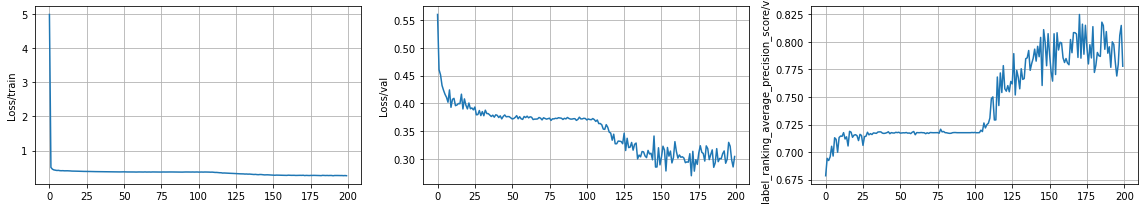

100%|██████████| 200/200 [39:26<00:00, 11.83s/it]


In [186]:
trainer(dataloader_ir_train, dataloader_ir_test, epochs = 200)

In [188]:
irpp2.history_dict['Loss/train']['Second'][0]=1

# Оценка качества модели

In [192]:
score = round(irpp2.history_dict['label_ranking_average_precision_score/val']['Second'][np.argmin(irpp2.history_dict['Loss/val']['Second'])],3)
epoch1 = np.argmin(irpp2.history_dict['Loss/val']['Second'])
print(f'Максимальная точность {score} на {epoch1} эпохе') 

Максимальная точность 0.825 на 170 эпохе


In [122]:
from sklearn.metrics import classification_report
def get_statistic(model, device, val_dataloader, tolerance = 0.9):
  y_true = []
  y_pred = []
  labels = []
  model.eval()
  for data, label in val_dataloader:
    out = model.to(device)(data.to(device))
    y_true.append(label)
    y_pred.append(out.cpu().detach().numpy())
    out.cpu()
  y_pred[0][y_pred[0]<tolerance]=0
  y_pred[0][y_pred[0]>=tolerance]=1
  model.to('cpu')
  return classification_report(y_true[0], y_pred[0], target_names = classes)


In [193]:
import gc
torch.cuda.empty_cache()
gc.collect()

77308

In [195]:
cr = get_statistic(model2, device, dataloader_ir_val, tolerance = 0.7)
print(cr)

                  precision    recall  f1-score   support

          alkane       0.94      0.79      0.86       818
          methyl       0.94      0.69      0.80       736
          alkene       1.00      0.08      0.14       159
          alkyne       0.00      0.00      0.00        21
        alcohols       0.94      0.35      0.51       270
          amines       0.97      0.20      0.34       153
        nitriles       0.00      0.00      0.00        34
       aromatics       0.96      0.89      0.92       712
   alkyl halides       0.97      0.09      0.17       330
          esters       0.94      0.12      0.22       128
         ketones       1.00      0.03      0.05       109
       aldehydes       0.00      0.00      0.00        17
carboxylic acids       0.75      0.04      0.07        81
           ether       1.00      0.28      0.44       274
    acyl halides       0.00      0.00      0.00        12
          amides       0.50      0.01      0.03        74
           ni

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
# from sklearn.metrics import label_ranking_average_precision_score
# score_list = []
# for i, j in dataloader_ir_val:
#   model1.eval()
#   model1.to(device)
#   out = model1(i.to(device))
#   #print(out)
#   #print(j)
#   score = label_ranking_average_precision_score(j, out.cpu().detach().numpy())
#   score_list.append(score)
# print(round(sum(score_list)/len(score_list), 2))

0.7


sklearn metrics - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


# Выводы

# Статистика

## 14.03.2023

Базовая модель - 0: 8 сверточных слоёв (3 макспула, после каждого удвоения признаков). hidden_size = 11. Точность 0.6 на 100 эпохах (переобучение). lr = 0.001
Количество параметров: порядка 18 млн

v0.1. 8 сверточных (3 макспула, удвоение 1 после второго). hidden_size = 11. Точность 0,45 на 40 эпохах, потом переобучение до 0,6. lr = 0.0005.
Количество параметров: 5,058,328

v0.2.0 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 hidden_size = 11.сверточный слой. Hidden_size = 11. ;r = 0.0005. Точность 0.43 20 эпохах, потом переобучение. 
Количество параметров: 350,158

v0.2.0.1 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой. Hidden_size = 20. lr = 0.0005. Точность 0.41 на 20 эпохах, потом переобучение. 
Количество параметров: 655,357

v0.2.1 вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.5). Hidden_size = 10. lr = 0.0005. label_ranking_average_precision_score **0,875** на 25 эпохах, потом переобучение. 
Количество параметров: 3,753,407

v0.2.2  вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.5) между первым и вторым fc. Hidden_size = 10. lr = 0.0005. label_ranking_average_precision_score **0,91** на 45 эпохах, потом переобучение. 
Количество параметров: 3,753,407

Подобрана функция для статистики. f1 score - дает среднее в 0,78.
Применил таки дропаут. 
v0.2.2  вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.5) между первым и вторым fc. Hidden_size = 10. lr = 0.0005. label_ranking_average_precision_score **0,80** на 66 эпохах, потом переобучение. Количество параметров: 3,753,407
На выходе полнота для низких классов вообще никакая. Хотя переобучение есть. Попробую снизить скорость и дропаут.

v0.2.3  вход+ 5 слоёв по 3 базовых блока по 2 сверки = 31 сверточный слой + 2 fc + 1 do (0.3) между первым и вторым fc. Hidden_size = 10. lr = 0.0003. label_ranking_average_precision_score **0,82** на 35 эпохах, потом переобучение. Количество параметров: 3,753,407
Полнота определения страдает для классов с низким содержанием.

v0.3.0 добавил  еще один дропаут и глубины.

вход+ 8 слоёв по 3 базовых блока по 2 сверки = 41 сверточный слой + 2 fc + 2 do (0.5 и 0,2) между первым и вторым fc. Hidden_size = 10. lr = 0.0003. label_ranking_average_precision_score **0.781 на 31 эпохе** , потом переобучение. Количество параметров: 3,907,127


##18.03.2023


18/03/2023
v0.3.1 убрал избыток сверток и добавил толщины.

вход+ 4 слоёв по 3 базовых блока по 2 сверки = 21 сверточный слой + 2 fc. 
Hidden_size = 20. 
lr = 0.0005. 

label_ranking_average_precision_score **0.871 на 8 эпохе** , потом переобучение. Количество параметров: 7,788,437.
Но в этом случае реколл для малых классов отличен от нуля. f1w - 0.76.
Добавим дропауты

v0.3.2 добавил дроп после flatten. Переобучение значительно снизилось. Не хватило 40 эпох. Высокий пресижон, но слабый рекол.Общий f1 0,5

вход+ 4 слоёв по 3 базовых блока по 2 сверки = 21 сверточный слой + 2 fc+1дроп. 
Hidden_size = 20. 
lr = 0.0005.  
label_ranking_average_precision_score ** 0.803 на 39 эпохе**

v0.3.3 увеличим толщину еще. вход+ 4 слоёв по 3 базовых блока по 2 сверки = 21 сверточный слой + 2 fc+1дроп. 
Hidden_size = 30. (Параметров 12,114,647) 
lr = 0.0005.  
label_ranking_average_precision_score **0.812 на 36 эпохе**


           precision    recall  f1-score   support
           alkane       0.97      0.51      0.67       812
           methyl       0.93      0.54      0.68       715
           alkene       1.00      0.10      0.19       165
           alkyne       1.00      0.16      0.27        19
         alcohols       0.94      0.18      0.31       271
           amines       1.00      0.07      0.13       159
         nitriles       1.00      0.02      0.04        46
        aromatics       0.98      0.75      0.85       681
    alkyl halides       0.92      0.14      0.24       317
           esters       0.97      0.43      0.60       129
          ketones       1.00      0.06      0.12       112
        aldehydes       1.00      0.39      0.56        23
    carboxylic acids    1.00      0.15      0.26        66
           ether        0.95      0.53      0.68       288
    acyl halides        0.50      0.07      0.12        14
          amides        0.60      0.03      0.06        96
           nitro        0.92      0.49      0.64        71

       micro avg        0.96      0.43      0.59      3984
       macro avg        0.92      0.27      0.38      3984
    weighted avg        0.95      0.43      0.55      3984
     samples avg        0.75      0.44      0.53      3984


v0.3.5 Повысим толщину еще. hidden_size = 50 (21,634,667 параметров). Модель не учится. А при расчёте статистики - еще и забивается память.

## 20.03.2023

20.03.2023
Добавлен взвешенный даталоадер на трейн. 

v0.3.6. 8 уровней по 3 базовых блока. Уже на 40 эпохах с lr = 0.001 выходит на плато. Потом уменьшение lr = 0.0005 и lr = 0.0001 приводит к улучшению результата максимум до label_ranking_average_precision_score 0.8 на 60 эпохе.
Но статистика говорит, что слабые классы всё равно не попадают под обучение.


                 precision    recall  f1-score   support

          alkane       0.94      0.64      0.76       818
          methyl       0.92      0.46      0.61       736
          alkene       0.90      0.17      0.29       159
          alkyne       0.00      0.00      0.00        21
        alcohols       0.89      0.14      0.25       270
          amines       0.83      0.16      0.26       153
        nitriles       0.00      0.00      0.00        34
       aromatics       0.99      0.82      0.90       712
    alkyl_halides      0.95      0.23      0.37       330
          esters       1.00      0.45      0.62       128
         ketones       0.91      0.18      0.31       109
       aldehydes       0.00      0.00      0.00        17
    carboxylic_acids   0.90      0.11      0.20        81
           ether       0.96      0.43      0.60       274
    acyl halides       1.00      0.17      0.29        12
          amides       1.00      0.08      0.15        74
           nitro       0.95      0.50      0.65        72

       micro avg       0.95      0.47      0.62      4000
       macro avg       0.77      0.27      0.37      4000
    weighted avg       0.92      0.47      0.59      4000
     samples avg       0.84      0.48      0.58      4000


v0.3.6.  4 уровней по 3 базовых блока.
label_ranking_average_precision_score  = 0.797 на 76 эпохе

                 precision    recall  f1-score   support

          alkane       0.99      0.48      0.64       818
          methyl       0.99      0.38      0.54       736
          alkene       0.00      0.00      0.00       159
          alkyne       1.00      0.24      0.38        21
        alcohols       1.00      0.12      0.22       270
          amines       0.00      0.00      0.00       153
        nitriles       0.00      0.00      0.00        34
       aromatics       0.99      0.44      0.61       712
    alkyl halides      1.00      0.00      0.01       330
          esters       0.00      0.00      0.00       128
         ketones       0.00      0.00      0.00       109
       aldehydes       0.50      0.06      0.11        17
    carboxylic acids   0.00      0.00      0.00        81
           ether       1.00      0.04      0.08       274
    acyl halides       0.00      0.00      0.00        12
          amides       1.00      0.01      0.03        74
           nitro       0.00      0.00      0.00        72

       micro avg       0.99      0.26      0.41      4000
       macro avg       0.50      0.10      0.15      4000
    weighted avg       0.81      0.26      0.36      4000
     samples avg       0.59      0.28      0.36      4000

Высокие точности для больших классов, никакие для слабых.

v0.3.7 Прикрутил AdaptiveMaxPool1d и планировщик (StepLR шаг 30 спектров, гамма = 0,2). label_ranking_average_precision_score = 0.83 на 73 эпохе
Статистика с толерантностью 0,9:

                  precision    recall  f1-score   support

          alkane       0.99      0.45      0.62       818
          methyl       0.96      0.26      0.41       736
          alkene       1.00      0.04      0.07       159
          alkyne       1.00      0.05      0.09        21
        alcohols       1.00      0.03      0.06       270
          amines       1.00      0.05      0.10       153
        nitriles       1.00      0.03      0.06        34
       aromatics       1.00      0.70      0.82       712
     alkyl halides     1.00      0.08      0.15       330
          esters       1.00      0.20      0.33       128
         ketones       1.00      0.04      0.07       109
       aldehydes       0.00      0.00      0.00        17
    carboxylic acids   1.00      0.05      0.09        81
           ether       1.00      0.26      0.41       274
    acyl halides       0.00      0.00      0.00        12
          amides       1.00      0.01      0.03        74
           nitro       1.00      0.32      0.48        72

       micro avg       0.99      0.31      0.47      4000
       macro avg       0.88      0.15      0.22      4000
    weighted avg       0.98      0.31      0.42      4000
     samples avg       0.71      0.32      0.42      4000

Статистика с толернатностью 0,7 - ф1 - 0,66

                  precision    recall  f1-score   support

          alkane       0.91      0.78      0.84       818
          methyl       0.89      0.69      0.78       736
          alkene       0.84      0.20      0.32       159
          alkyne       1.00      0.24      0.38        21
        alcohols       0.85      0.15      0.26       270
          amines       0.91      0.20      0.32       153
        nitriles       1.00      0.15      0.26        34
       aromatics       0.98      0.90      0.93       712
     alkyl halides     0.93      0.26      0.41       330
          esters       0.96      0.40      0.56       128
         ketones       0.92      0.21      0.34       109
       aldehydes       1.00      0.06      0.11        17
    carboxylic acids   0.94      0.19      0.31        81
           ether       0.95      0.50      0.65       274
    acyl halides       0.00      0.00      0.00        12
          amides       0.89      0.11      0.19        74
           nitro       0.97      0.51      0.67        72

       micro avg       0.93      0.56      0.70      4000
       macro avg       0.88      0.33      0.43      4000
    weighted avg       0.92      0.56      0.66      4000
     samples avg       0.88      0.58      0.67      4000


v0.3.8 hidden_size = 15 (5 млн параметров), 8 слоёв. два дропаута.
точность 0.825 на 170 эпохе.
Статистика на 0,7:

                precision    recall  f1-score   support

          alkane       0.94      0.79      0.86       818
          methyl       0.94      0.69      0.80       736
          alkene       1.00      0.08      0.14       159
          alkyne       0.00      0.00      0.00        21
        alcohols       0.94      0.35      0.51       270
          amines       0.97      0.20      0.34       153
        nitriles       0.00      0.00      0.00        34
       aromatics       0.96      0.89      0.92       712
     alkyl halides     0.97      0.09      0.17       330
          esters       0.94      0.12      0.22       128
         ketones       1.00      0.03      0.05       109
       aldehydes       0.00      0.00      0.00        17
    carboxylic acids   0.75      0.04      0.07        81
           ether       1.00      0.28      0.44       274
    acyl halides       0.00      0.00      0.00        12
          amides       0.50      0.01      0.03        74
           nitro       1.00      0.14      0.24        72

       micro avg       0.95      0.52      0.67      4000
       macro avg       0.70      0.22      0.28      4000
    weighted avg       0.92      0.52      0.60      4000
     samples avg       0.90      0.54      0.64      4000

Везде наблюдаются высокие precision и низкие recall, за исключением самых крупных классов. Самые редкие классы по нулям. 
Требуется научиться аугментации спектров, повысить количество малых классов, хотя бы раз в 10-100. 

Планы: 

*   Заняться аугментацией спектров
*   Самые редкие классы выделить и аугментировать многократно. 
*   Используя имеющуюся модель научиться определять полосы частых классов и аугментировать спектры, вырежая эти диапазоны.
*   Научиться работать со спектрами других размеров.




